In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC
from sklearn.utils import compute_class_weight



%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
batch_size = 64
target_size = (64, 64)
train_dir = '../../src/data2/train'
val_dir = '../../src/data2/val'
test_dir = '../../src/data2/test'
num_of_test_samples = len(glob.glob('../../src/data2/test/*/*.jpg'))

dagenerator = ImageDataGenerator(rescale=1./255)

train_generator  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(directory = val_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = batch_size)

test_generator = dagenerator.flow_from_directory(directory = test_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = num_of_test_samples)

class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
dict_class_weights = dict(enumerate(class_weights));
print(f' Class weights: {dict_class_weights}');

Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 961 images belonging to 4 classes.
 Class weights: {0: 1.7858851674641147, 1: 25.448863636363637, 2: 0.49988839285714287, 3: 0.7141262755102041}


In [5]:
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate = 1e-4),
              metrics= ['acc', 'AUC'])


#Fit perameters
earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              restore_best_weights= True,
                              verbose = 1)

filepath = '../../src/best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callbacks = [earlystopping, checkpoint]
epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history = model.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
69/69 [==============================] - ETA: 0s - loss: 1.3947 - acc: 0.2451 - auc: 0.5331
Epoch 00001: val_acc improved from -inf to 0.30915, saving model to ../../src/best_weights.hdf5
69/69 [==============================] - 6s 82ms/step - loss: 1.3947 - acc: 0.2451 - auc: 0.5331 - val_loss: 1.3940 - val_acc: 0.3092 - val_auc: 0.4505
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 1.3572 - acc: 0.3042 - auc: 0.5779
Epoch 00002: val_acc improved from 0.30915 to 0.43527, saving model to ../../src/best_weights.hdf5
69/69 [==============================] - 6s 87ms/step - loss: 1.3572 - acc: 0.3042 - auc: 0.5779 - val_loss: 1.3285 - val_acc: 0.4353 - val_auc: 0.7086
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 1.3544 - acc: 0.3767 - auc: 0.6464
Epoch 00003: val_acc improved from 0.43527 to 0.45089, saving model to ../../src/best_weights.hdf5
69/69 [=======

In [7]:
model = load_model('../../src/best_weights.hdf5')

In [9]:
from src.mymods import Vis_results

Instructions for updating:
Please use Model.predict, which supports generators.
-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.99      0.96      0.97       135
    Moderate       1.00      1.00      1.00        11
        None       0.98      0.93      0.95       480
   Very Mild       0.89      0.98      0.93       335

    accuracy                           0.95       961
   macro avg       0.97      0.97      0.97       961
weighted avg       0.95      0.95      0.95       961

------------------------Confusion Matrix---------------------------


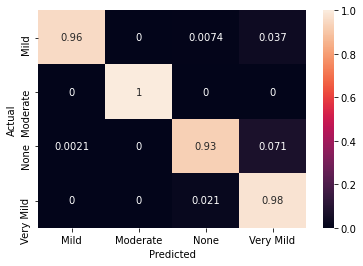

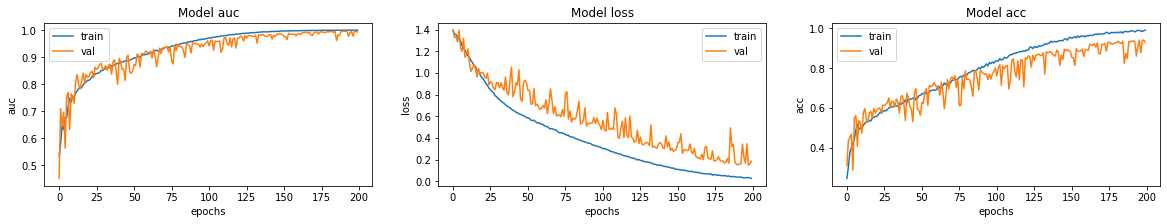

In [10]:
Vis_results(model, history, test_generator, test_generator.n, batch_size)